In [1]:
D_PATH = '/Volumes/T5/cvpdata/shapestacks'

In [2]:
# --------------------------------------------------------
# Written by Yufei Ye (https://github.com/JudyYe)
# --------------------------------------------------------
from __future__ import print_function

import glob
import os

import numpy as np
# import debug_init_paths
import torch
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader

from utils.data_utils import imagenet_preprocess, Resize

In [3]:
class Dataset(object):
    r"""An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs a index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

    # No `def __len__(self)` default?
    # See NOTE [ Lack of Default `__len__` in Python Abstract Base Classes ]
    # in pytorch/torch/utils/data/sampler.py

In [4]:
class ShapeStacks(Dataset):
    def __init__(self, image_dir, list_path, dt, radius, mod,
                 normalize_images=True, max_samples=None, training=False):
        Dataset.__init__(self)

        self.RW = self.RH = self.W = self.H = 224
        self.orig_W = self.orig_H = 224
        self.box_rad = radius

        self.image_dir = image_dir
        self.ext = '.jpg'
        self.max_samples = max_samples
        self.dt = dt
        self.num_obj = 0
        self.training = training
        self.modality = mod

        transform = [Resize((self.H, self.W)), T.ToTensor()]
        obj_transform = [Resize((self.RH, self.RW)), T.ToTensor()]
        if normalize_images:
            transform.append(imagenet_preprocess())
            obj_transform.append(imagenet_preprocess())
        self.transform = T.Compose(transform)
        self.obj_transform = T.Compose(obj_transform)

        with open(list_path) as fp:
            self.index_list = [line.split()[0] for line in fp]
        self.roidb = self.parse_gt_roidb()
        eg_path = glob.glob(os.path.join(self.image_dir, self.index_list[0], self.modality + '*' + self.ext))[0]
        self.image_pref = '-'.join(os.path.basename(eg_path).split('-')[0:-1])

    def parse_gt_roidb(self):
        roidb = {}
        for index in self.index_list:
            gt_path = os.path.join(self.image_dir, index, 'cam_1.npy')
            bbox = np.load(gt_path) ## 32, 3, 2 in (0, 224) coor
            roidb[index] = bbox
            self.num_obj = bbox.shape[1]
        return roidb

    def __len__(self):
        num = len(self.index_list)
        if self.max_samples is not None:
            return min(self.max_samples, num)
        return num

    def __getitem__(self, index):
        """
        :return: src, dst. each is a list of object
        - 'image': FloatTensor of shape (dt, C, H, W). resize and normalize to faster-rcnn
        - 'crop': (O, C, RH, RW) RH >= 224
        - 'bbox': (O, 4) in xyxy (0-1) / xy logw logh
        - 'trip': (T, 3)
        - 'index': (dt,)
        """
        vid_point = []
        for dt in range(self.dt):
            this_index = self.get_index_after(self.index_list[index], dt)
            vid_obj = {}
            norm_bbox = self.roidb[self.index_list[index]][dt] # (O, 2)
            bboxes = np.vstack((norm_bbox[:, 0] * self.orig_W, norm_bbox[:, 1] * self.orig_H)).T
            image, crops = self._read_image(this_index, bboxes)

            trip = self._build_graph(this_index)
            vid_obj['index'] = this_index
            vid_obj['image'] = image
            vid_obj['crop'] = crops
            vid_obj['bbox'] = torch.FloatTensor(norm_bbox)
            vid_obj['trip'] = trip
            valid = np.arange(3, dtype=np.int64)
            vid_obj['info'] = (self.orig_W, self.orig_H, valid)
            vid_obj['valid'] = torch.LongTensor(valid)

            vid_point.append(vid_obj)
        return vid_point

    def get_index_after(self, index, dt):
        return os.path.join(index, self.image_pref + '-%02d' % dt)

    def _read_image(self, index, bboxes):
        image_path = os.path.join(self.image_dir, index) + self.ext
        with open(image_path, 'rb') as f:
            with Image.open(f) as image:
                dst_image = self.transform(image.convert('RGB'))
                crops = self._crop_image(index, image, bboxes)
        return dst_image, crops

    def _crop_image(self, index, image, box_center):
        crop_obj = []
        x1 = box_center[:, 0] - self.box_rad
        y1 = box_center[:, 1] - self.box_rad
        x2 = box_center[:, 0] + self.box_rad
        y2 = box_center[:, 1] + self.box_rad
        bbox = np.vstack((x1, y1, x2, y2)).transpose()
        for d in range(len(box_center)):
            crp = image.crop(bbox[d]).convert('RGB')
            crp = self.transform(crp)
            crop_obj.append(crp)
        crop_obj = torch.stack(crop_obj)
        return crop_obj

    def _build_graph(self, index):
        all_trip = np.zeros([0, 3], dtype=np.float32)
        for i in range(self.num_obj):
            for j in range(self.num_obj):
                trip = [i, 0, j]
                all_trip = np.vstack((all_trip, trip))
        return torch.FloatTensor(all_trip)


def dt_collate_fn(batch):
    """
    :return: src dst. each is a list with dict element
    - 'index': list of str with length N
    - 'image': list of FloatTensor in shape (Dt, V, 1, C, H, W)
    - 'crop': list of FloatTensor in shape (Dt, V, o, C, RH, RW)
    - 'bbox': (Dt, V, o, 4)
    - 'trip': (Dt, V, t, 3)
    """
    key_set = ['index', 'image', 'crop', 'bbox', 'trip', 'valid']
    all_batch = {}
    dt = len(batch[0])
    V = len(batch)
    for key in key_set:
        all_batch[key] = []

    for f in range(dt):
        for v in range(len(batch)):
            frame = batch[v][f]
            for key in key_set:
                all_batch[key].append(frame[key])

    for key in all_batch:
        if key == 'index':
            continue
        if key in ['image', 'crop']:
            tensor = torch.stack(all_batch[key])
            all_batch[key] = tensor.view(dt, V, -1, 3, tensor.size(-2), tensor.size(-1))
        elif key in ['bbox', 'trip', 'valid']:
            tensor = torch.stack(all_batch[key])
            all_batch[key] = tensor.view(dt, V, -1, tensor.size(-1))
        else:
            print('key not exist', key)
            raise KeyError

    return all_batch


def build_vid_loaders(args):
    dset_kwargs = {
        'max_samples': None,
        'dt': args.dt,
        'radius': args.radius,
        'training': args.is_train,
        'mod': 'rgb' # args.modality
    }
    loader_kwargs = {
        'batch_size': args.batch_size,
        'num_workers': args.loader_num_workers,
        'collate_fn': dt_collate_fn,
    }

    fov = 35
    common_list = 'data/shapestacks/splits/'
    dset_kwargs['image_dir'] = 'data/shapestacks/frc_%d/' % fov
    if args.dataset in ['ss3']:
        common_list = common_list + '/env_ccs+blocks-hard+easy-h=3-vcom=1+2+3-vpsf=0/'
    else:
        num = int(args.dataset[2])
        common_list = common_list + '/env_ccs+blocks-hard+easy-h=%d-vcom=1+2+3+4+5+6-vpsf=0/' % num

    dset_kwargs['training'] = args.is_train
    if args.is_train:
        dset_kwargs['list_path'] = common_list + 'train.txt'
        loader_kwargs['shuffle'] = True
    else:
        print('val')
        dset_kwargs['list_path'] = common_list + 'eval.txt'
        dset_kwargs['max_samples'] = args.num_val_samples
        loader_kwargs['shuffle'] = args.shuffle_val
    if not os.path.exists(dset_kwargs['list_path']):
        print('not exists', dset_kwargs['list_path'])
        raise FileExistsError
    train_dset = ShapeStacks(**dset_kwargs)

    loader = DataLoader(train_dset, **loader_kwargs)

    return loader


In [5]:
key_set = ['index', 'image', 'crop', 'bbox', 'trip']

In [6]:
dset_kwargs = {
        'max_samples': None,
        'dt': 32,
        'radius': 35,
        'training': True,
        'mod': 'rgb' # args.modality
    }
dset_kwargs['image_dir'] = D_PATH + '/frc_%d/' % 35

common_list = D_PATH + '/splits/'
common_list = common_list + '/env_ccs+blocks-hard+easy-h=3-vcom=1+2+3-vpsf=0/'

dset_kwargs['list_path'] = common_list + 'train.txt'
dset_kwargs['list_path'] = common_list + 'train.txt'

In [7]:
train_dset = ShapeStacks(**dset_kwargs)

In [8]:
train_dset

In [9]:
from torch.utils.data import Dataset, DataLoader

In [10]:
def dt_collate_fn(batch):
    """
    :return: src dst. each is a list with dict element
    - 'index': list of str with length N
    - 'image': list of FloatTensor in shape (Dt, V, 1, C, H, W)
    - 'crop': list of FloatTensor in shape (Dt, V, o, C, RH, RW)
    - 'bbox': (Dt, V, o, 4)
    - 'trip': (Dt, V, t, 3)
    """
    key_set = ['index', 'image', 'crop', 'bbox', 'trip', 'valid']
    all_batch = {}
    dt = len(batch[0])
    V = len(batch)
    for key in key_set:
        all_batch[key] = []

    for f in range(dt):
        for v in range(len(batch)):
            frame = batch[v][f]
            for key in key_set:
                all_batch[key].append(frame[key])

    for key in all_batch:
        if key == 'index':
            continue
        if key in ['image', 'crop']:
            tensor = torch.stack(all_batch[key])
            all_batch[key] = tensor.view(dt, V, -1, 3, tensor.size(-2), tensor.size(-1))
        elif key in ['bbox', 'trip', 'valid']:
            tensor = torch.stack(all_batch[key])
            all_batch[key] = tensor.view(dt, V, -1, tensor.size(-1))
        else:
            print('key not exist', key)
            raise KeyError

    return all_batch

loader_kwargs = {
        'batch_size': 1,
        'num_workers': 7,
        'collate_fn': dt_collate_fn,
    }
loader_kwargs['shuffle'] = True

loader = DataLoader(train_dset, **loader_kwargs)

In [11]:
loader

In [12]:
b = 0
for idx, x in enumerate(loader):
    if idx > 1: break
    b = x

In [15]:
set1 = b

In [16]:
set1.keys()

['index', 'image', 'crop', 'valid', 'bbox', 'trip']

In [31]:
image1 = set1['image']



torch.Size([32, 1, 1, 3, 224, 224])

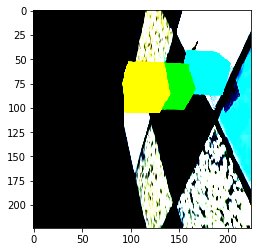

In [21]:
import matplotlib.pyplot as plt
plt.imshow(image1[0][0][0].T)
plt.show()

torch.Size([32, 1, 3, 3, 224, 224])


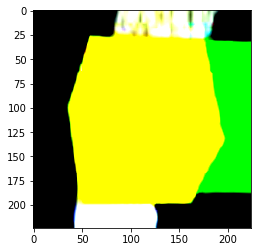

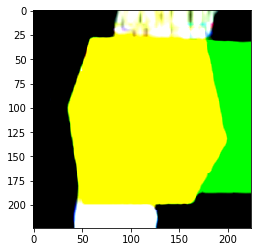

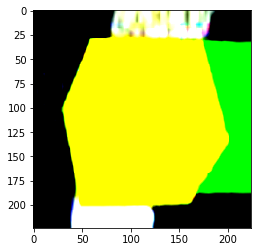

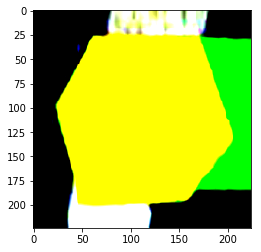

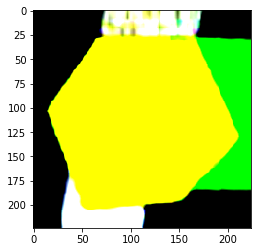

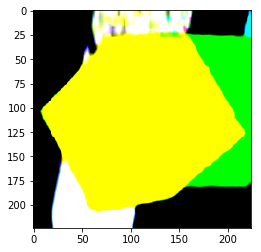

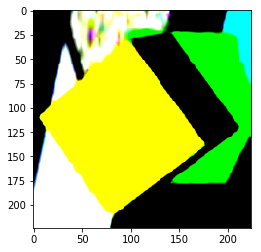

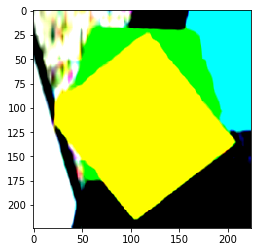

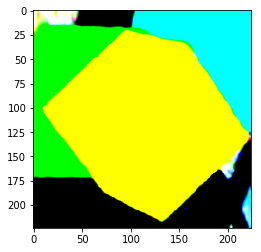

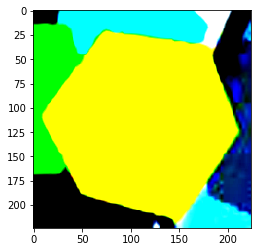

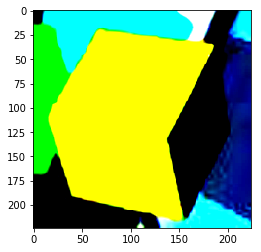

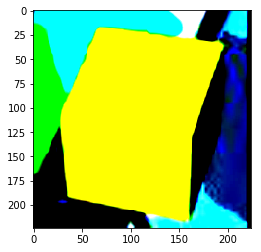

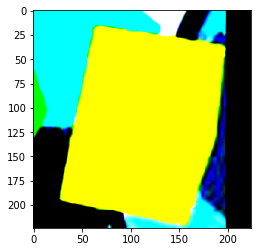

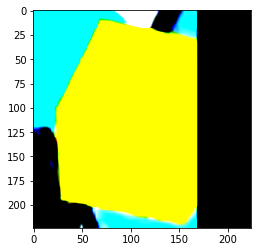

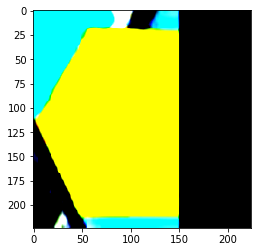

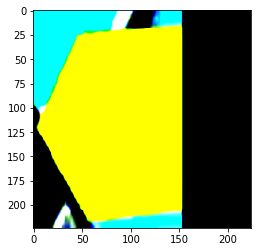

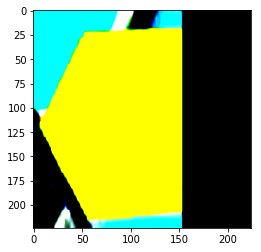

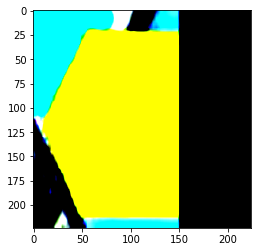

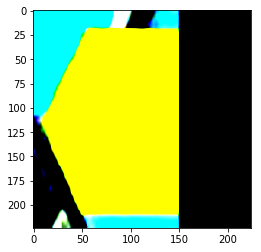

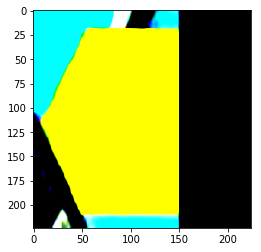

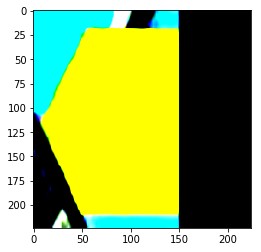

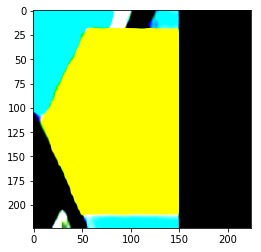

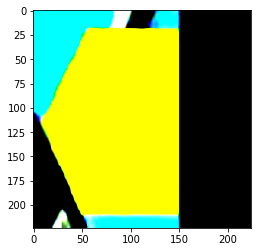

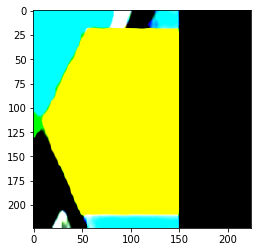

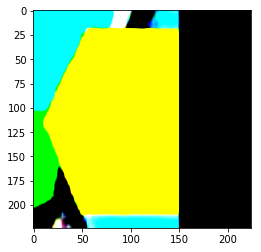

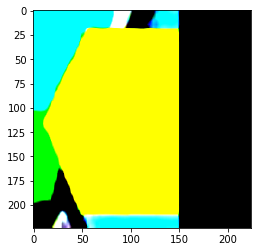

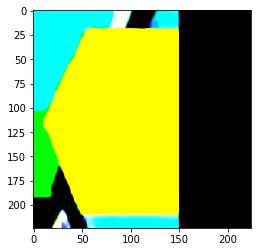

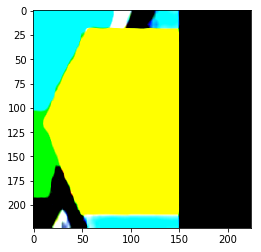

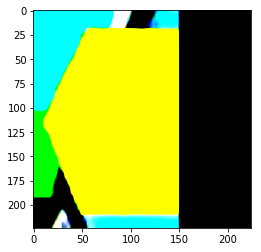

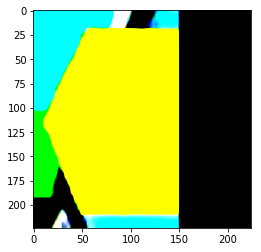

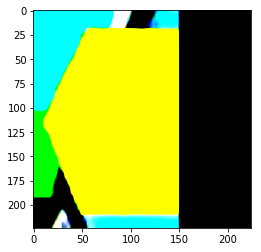

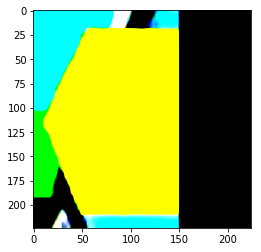

In [23]:
crop1 = set1['crop']
print(crop1.shape)
for i in range(crop1.shape[0]):
    plt.imshow(crop1[i][0][0].T)
    plt.show()

In [25]:
bbox1 = set1['bbox']
print(bbox1.shape)
bbox1[0]

torch.Size([32, 1, 3, 2])


tensor([[[0.3518, 0.5135],
         [0.3454, 0.6297],
         [0.2798, 0.7854]]])

In [26]:
index1 = set1['index']
index1

['env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-00',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-01',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-02',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-03',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-04',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-05',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-06',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-07',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-08',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-09',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-10',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-11',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-12',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-13',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-14',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-15',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam_1-16',
 'env_blocks-hard-h=3-vcom=2-vpsf=0-v=25/rgb-cam

In [29]:
trip1 = set1['trip']
trip1[0]

tensor([[[0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 2.],
         [1., 0., 0.],
         [1., 0., 1.],
         [1., 0., 2.],
         [2., 0., 0.],
         [2., 0., 1.],
         [2., 0., 2.]]])

KeyError: 31